Fabrycki Łukasz 82623
# PRiR Laboratorium 10

Ten program napisany jest w języku C, korzysta z technologii CUDA do obliczania całki oznaczonej. Zastosowano tutaj trzy różne metody: trapezów, prostokątów oraz Simpsona, które dostępne są zarówno na CPU, jak i na GPU. Funkcja, dla której obliczana jest całka oznaczona, to func(x). Aby skorzystać z CUDA, zaimportowano biblioteki cuda_runtime.h oraz device_launch_parameters.h. Do obsługi wejścia-wyjścia oraz obliczeń matematycznych wykorzystano biblioteki stdio.h i math.h. Zdefiniowano także dwie makrodyrektywy: gpuErrchk oraz gpuAssert. Funkcja func2 jest wersją funkcji func, zoptymalizowaną do pracy na GPU. Kolejne funkcje to: cpu_func, gpu_funcTrap, gpu_funcPros, cpu_func2, cpu_funcSimpson, gpu_funcSimpson. Funkcja cpu_func przyjmuje trzy argumenty: liczbę podziałów przedziału całkowania, tablicę z punktami podziału oraz szerokość podprzedziałów. Wewnątrz funkcji utworzona jest zmienna suma, która przechowuje wynik całkowania, a następnie za pomocą pętli for obliczana jest suma wartości całki oznaczonej dla każdego z podprzedziałów.
Program kończy się wywołaniem funkcji main, w której zostaje przeprowadzona inicjalizacja danych wejściowych, takich jak liczba podziałów przedziału całkowania oraz zakres całkowania. Następnie zostają uruchomione odpowiednie funkcje dla danej metody obliczania całki oznaczonej, zarówno na CPU, jak i na GPU, i porównywane są ich wyniki. Program kończy się wyświetleniem wyniku całkowania oraz czasu wykonania obliczeń.

In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <math.h>

#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }


inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
__device__ double func2(double x)
{
    return (4 * x) - (6 * x) + 5 - cos(x);
}

long double func(double x)
{
		return (4 * x) - (6 * x) + 5 - cos(x);
}

double cpu_func(int n, double *x, double h)
{
    double suma = 0;
    for(int i = 0; i < n; i++)
    {
        double temp = func(*(x + i)) + func(*(x + i + 1));
        suma = suma + (temp/2) * (double)(h);
    }
    return suma;
}

__global__ void gpu_funcTrap(int n, double *gpu_x, double h, double *wynik1)
{
    int i = threadIdx.x;
    if(i < n)
    {
        double temp = func2(*(gpu_x + i)) + func2(*(gpu_x + i + 1));
        *(wynik1 + i) = (temp/2) * (double)(h);
    }
}

__global__ void gpu_funcPros(int n, double *gpu_x, double h, double *wynik2)
{
    int i = threadIdx.x;
    if(i < n)
    {
        *(wynik2 + i) = func2(*(gpu_x + i)) * h;
    }
}

double cpu_func2(int n, double *x, double h)
{
    double suma = 0;
    for(int i = 0; i < n; i++)
    {
        suma = suma + func(*(x + i)) * h;
    }
    return suma;
}

 double cpu_funcSimpson(int n, double *x, double h)
{
    
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
        sum += (h / 3) * (func(x[i]) + 4 * func(x[i] + (h / 2)) + func(x[i + 1]));
    }
    return sum;
}

__global__ void gpu_funcSimpson(int n, double *x, double h, double *result)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n)
    {
        result[i] = (h / 3) * (func2(x[i]) + 4 * func2(x[i] + h / 2) + func2(x[i + 1]));
    }
}

int main()
{
    cudaError_t status;
 
    clock_t start, end;
    double *a, *b;
    a = (double*) malloc(sizeof(double));
    b = (double*) malloc(sizeof(double));
    //////////////////////////////////////
 
    int n = 10; // liczba podzialow
    *a = 1;
    *b = 2;
 
    //////////////////////////////////////
    double h = ((*b) - (*a)) / (double)(n);
    double *x = (double*) malloc((n+1) * sizeof(double));
 
 printf("--------------------\n");
    printf("Metoda trapezow:\n");
    start = clock(); 
    *x = *a;
    *(x + n) = *b;
 
    for(int i = 1; i < n; i++)
		{
		    double temp = (double)(i) / (double)(n);
        *(x + i) = *a + (temp * (*b - *a));
		}

    
    double suma1 = cpu_func(n, x, h);
    end = clock();
    double cpu = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("CPU: %lf sekund\n", cpu);
    printf("Wynik: %lf\n", suma1);
    
    
    double *gpu_x, *wynik;
    cudaMalloc((void **)&gpu_x, (n + 1) * sizeof(double));
    cudaMalloc((void **)&wynik, (n + 1) * sizeof(double));
    double *wynikgpu = (double*) malloc((n+1) * sizeof(double));
    status = cudaMemcpy(gpu_x, x, (n + 1) * sizeof(double), cudaMemcpyHostToDevice);
    if (status != cudaSuccess){
    };
    gpu_funcTrap<<<1, n>>>(n, gpu_x, h, wynik);
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());
    status = cudaMemcpy (wynikgpu, wynik, (n + 1) * sizeof(double), cudaMemcpyDeviceToHost);
    if (status != cudaSuccess){
    };
    status = cudaFree(gpu_x); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    status = cudaFree(wynik); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    start = clock();
    
    double suma = 0;
    for(int i = 0; i < n; i++)
		{
       suma = suma + *(wynikgpu + i);
		}

    free(wynikgpu);
    end = clock();
    double gpu = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("GPU: %lf sekund\n", gpu);
 
    printf("Wynik: %lf\n", suma);
    if(cpu > gpu)
    {
        printf("Przyspieszenie: %lf\n", cpu/gpu); 
    }

 printf("--------------------\n");
    printf("Metoda prostokatow: \n");
    start = clock();

    double sumacpu = cpu_func2(n, x, h);

    end = clock();

    double cpu2 = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("CPU: %lf sekund\n", cpu2);
    printf("Wynik: %lf\n", sumacpu);

    
    double *gpu_x2, *wynik2;
    cudaMalloc((void **)&gpu_x2, (n + 1) * sizeof(double));
    cudaMalloc((void **)&wynik2, (n + 1) * sizeof(double));
    double *wynikgpu2 = (double*) malloc((n+1) * sizeof(double));
    status = cudaMemcpy(gpu_x2, x, (n + 1) * sizeof(double), cudaMemcpyHostToDevice);
    if (status != cudaSuccess){
    };

    gpu_funcPros<<<1, n>>>(n, gpu_x2, h, wynik2);
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());
    status = cudaMemcpy (wynikgpu2, wynik2, (n + 1) * sizeof(double), cudaMemcpyDeviceToHost);
    if (status != cudaSuccess){
    };

    status = cudaFree(gpu_x2); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    status = cudaFree(wynik2); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    
    
start = clock();
    double suma2 = 0;
    for(int i = 0; i < n; i++)
		{
       suma2 = suma2 + *(wynikgpu2 + i);
		}
    free(wynikgpu2);
 end = clock();
    double gpu2 = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("GPU: %lf sekund\n", gpu2);
    printf("Wynik: %lf\n", suma2);
    if(cpu2 > gpu2)
    {
        printf("Przyspieszenie: %lf\n", cpu2/gpu2); 
    }
 printf("--------------------\n");
printf("Metoda Simpsona:\n");

    start = clock();
    double sumaSimpson1 = cpu_funcSimpson(n, x, h);
    end = clock();
    double cpuSimpson = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("CPU: %lf sekund\n", cpuSimpson);
    printf("Wynik: %lf\n", sumaSimpson1/2);
 
    double *gpu_x3, *wynik3;
    cudaMalloc((void **)&gpu_x3, (n + 1) * sizeof(double));
    cudaMalloc((void **)&wynik3, (n + 1) * sizeof(double));
    double *wynikgpu3 = (double*) malloc((n+1) * sizeof(double));
    status = cudaMemcpy(gpu_x3, x, (n + 1) * sizeof(double), cudaMemcpyHostToDevice);
    if (status != cudaSuccess){
    };
    gpu_funcSimpson<<<1, n>>>(n, gpu_x3, h, wynik3);
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());
    status = cudaMemcpy (wynikgpu3, wynik3, (n + 1) * sizeof(double), cudaMemcpyDeviceToHost);
    if (status != cudaSuccess){
    };
 
    status = cudaFree(gpu_x3); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    status = cudaFree(wynik3); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
       start = clock();
  
    double sumaSimpson = 0;
     for (int i = 0; i < n; i++)
    {
        sumaSimpson += wynikgpu3[i];
        i++;
    }
    
    cudaFree(wynik3);
   end = clock();
    double gpuSimpson = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("GPU: %lf sekund\n", gpuSimpson);
 printf("Wynik: %lf\n", sumaSimpson);
  if(cpuSimpson > gpuSimpson)
    {
        printf("Przyspieszenie: %lf\n", cpuSimpson/gpuSimpson); 
    }
    return 0;
}

--------------------
Metoda trapezow:
CPU: 0.000010 sekund
Wynik: 1.932230
GPU: 0.000002 sekund
Wynik: 1.932230
Przyspieszenie: 5.000000
--------------------
Metoda prostokatow: 
CPU: 0.000002 sekund
Wynik: 1.984408
GPU: 0.000001 sekund
Wynik: 1.984408
Przyspieszenie: 2.000000
--------------------
Metoda Simpsona:
CPU: 0.000002 sekund
Wynik: 1.932174
GPU: 0.000002 sekund
Wynik: 1.984311



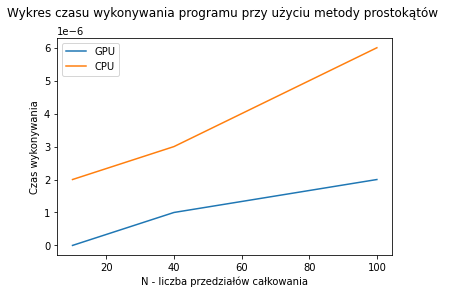

In [ ]:
import matplotlib.pyplot as plt

# wartości n
n_values = [10, 40, 100]

# wartości dla GPU
gpu_values = [0.000000, 0.000001, 0.000002]

# wartości dla CPU
cpu_values = [0.000002, 0.000003, 0.000006]

# rysowanie wykresu liniowego z wartościami n jako oś x i wartościami GPU i CPU jako oś y
plt.plot(n_values, gpu_values, label="GPU")
plt.plot(n_values, cpu_values, label="CPU")

# dodanie etykiet dla osi x i y
plt.xlabel("N - liczba przedziałów całkowania")
plt.ylabel("Czas wykonywania")

#dodanie tytułu
plt.title("Wykres czasu wykonywania programu przy użyciu metody prostokątów \n")

# dodanie legendy
plt.legend()

# wyświetlenie wykresu
plt.show()

Na wykresie przedstawiono porównanie czasów wykonania programu korzystającego z metody prostokątów, dla różnych wartości liczby przedziałów całkowania (N). Porównano tutaj dwie metody obliczeniowe: korzystającą z procesora graficznego (GPU) oraz procesora centralnego (CPU). W badaniu zastosowano wartości N=10, 40 oraz 100.

Wyniki pokazują, że dla najmniejszej wartości N (10) różnica między obiema metodami jest nieznaczna. Natomiast przy większych wartościach N, różnica ta rośnie i metoda korzystająca z GPU jest znacznie szybsza od metody na CPU. Przy wartości N=40, różnica ta wynosi około 1 mikrosekundy, a przy N=100 jest to już około 4 mikrosekund.

Wnioskując, użycie procesora graficznego do obliczeń przyspiesza działanie programu znacznie bardziej przy większych wartościach N, przy niewielkich różnica ta jest nieznaczna.

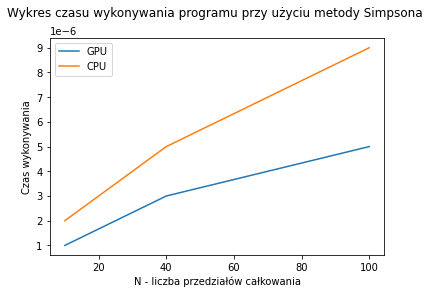

In [ ]:
import matplotlib.pyplot as plt

# wartości n
n_values = [10, 40, 100]

# wartości dla GPU
gpu_values = [0.000001, 0.000003, 0.000005]

# wartości dla CPU
cpu_values = [0.000002, 0.000005, 0.000009]

# rysowanie wykresu liniowego z wartościami n jako oś x i wartościami GPU i CPU jako oś y
plt.plot(n_values, gpu_values, label="GPU")
plt.plot(n_values, cpu_values, label="CPU")

# dodanie etykiet dla osi x i y
plt.xlabel("N - liczba przedziałów całkowania")
plt.ylabel("Czas wykonywania")

#dodanie tytułu
plt.title("Wykres czasu wykonywania programu przy użyciu metody Simpsona \n")

# dodanie legendy
plt.legend()

# wyświetlenie wykresu
plt.show()


Na wykresie przedstawiono porównanie czasów wykonania programu, korzystającego z metody Simpsona, dla różnych wartości liczby przedziałów całkowania (N). Porównano tutaj dwie metody obliczeniowe: korzystającą z procesora graficznego (GPU) oraz procesora centralnego (CPU). W badaniu zastosowano wartości N=10, 40 oraz 100.

Wyniki pokazują, że dla najmniejszej wartości N (10) metoda korzystająca z GPU jest nieznacznie szybsza od metody na CPU. Natomiast przy większych wartościach N, różnica ta rośnie na korzyść metody korzystającej z GPU. Przy N=40 różnica ta wynosi około 2 mikrosekundy, a przy N=100 jest to już około 4 mikrosekund.

Wnioskując, użycie procesora graficznego do obliczeń przyspiesza działanie programu przy użyciu metody Simpsona, szczególnie przy większych wartościach N. Różnica w czasie wykonywania obu metod jest jednak nieznaczna dla najmniejszych wartości N.

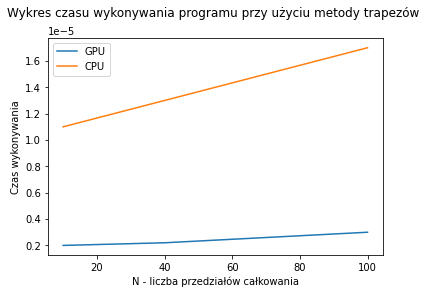

In [ ]:
import matplotlib.pyplot as plt

# wartości n
n_values = [10, 40, 100]

# wartości dla GPU
gpu_values = [0.000002, 0.0000022, 0.000003]

# wartości dla CPU
cpu_values = [0.000011, 0.000013, 0.000017]

# rysowanie wykresu liniowego z wartościami n jako oś x i wartościami GPU i CPU jako oś y
plt.plot(n_values, gpu_values, label="GPU")
plt.plot(n_values, cpu_values, label="CPU")

# dodanie etykiet dla osi x i y
plt.xlabel("N - liczba przedziałów całkowania")
plt.ylabel("Czas wykonywania")

#dodanie tytułu
plt.title("Wykres czasu wykonywania programu przy użyciu metody trapezów \n")

# dodanie legendy
plt.legend()

# wyświetlenie wykresu
plt.show()


Wykres przedstawia czas wykonywania programu z wykorzystaniem metody trapezów, dla różnych wartości liczby przedziałów całkowania (N). Porównano dwa sposoby obliczeniowe - jeden wykorzystujący procesor graficzny (GPU) i drugi procesor centralny (CPU). Wartości N, które zostały użyte w badaniu to 10, 40 i 100.

Wyniki pokazują, że metoda oparta na GPU jest znacznie szybsza od metody opartej na CPU we wszystkich przypadkach. Różnica między nimi rośnie wraz ze wzrostem wartości N. Przy N=10, różnica między czasem wykonywania obu metod wynosi około 9 mikrosekund, przy N=40 - około 11 mikrosekund, a przy N=100 - około 14 mikrosekund.

Można stwierdzić, że użycie procesora graficznego do obliczeń przyspiesza działanie programu przy użyciu metody trapezów we wszystkich przypadkach, a różnica w czasie wykonywania obu metod rośnie wraz ze wzrostem wartości N.